# IEEE Fraud Detection Kaggle Competition
## LightGBM card1 count encoding plus bootstrapping and repeated holdout validation

In [2]:
%%bash

ls -l

cd data 

ls -l

total 14344
-rw-r--r--  1 cchadha2  749149485  1976809 Aug  9 10:16 EDA.ipynb
-rw-r--r--  1 cchadha2  749149485  1661687 Jul 29 22:42 IDs-EDA.ipynb
-rw-r--r--  1 cchadha2  749149485   222386 Aug  8 22:25 adverserial_validation.ipynb
-rw-r--r--  1 cchadha2  749149485   667100 Aug 12 23:18 lgb_TransactionDay_and_TransactionHour.ipynb
-rw-r--r--  1 cchadha2  749149485   550964 Aug 12 23:17 lgb_TransactionHour.ipynb
-rw-r--r--  1 cchadha2  749149485   237097 Aug  7 15:28 lightgbm_baseline.ipynb
-rw-r--r--  1 cchadha2  749149485   335980 Aug  9 10:15 lightgbm_card1_count_encoded.ipynb
-rw-r--r--  1 cchadha2  749149485   230960 Aug  8 22:25 lightgbm_card1_count_encoded_20kval.ipynb
-rw-r--r--  1 cchadha2  749149485   867988 Jul 30 18:23 log_reg.ipynb
-rw-r--r--  1 cchadha2  749149485   573592 Aug  7 22:19 val_indices_>0.5.npy
total 14344
-rw-r--r--  1 cchadha2  749149485  1976809 Aug  9 10:16 EDA.ipynb
-rw-r--r--  1 cchadha2  749149485  1661687 Jul 29 22:42 IDs-EDA.ipynb
-rw-r--r--  1 cchadh

bash: line 4: cd: data: No such file or directory


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

/Users/cchadha2/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
pd.set_option('display.max_columns', 500)
num_folds = 5
SEED = 5000

# Load and prepare data

In [5]:
train = pd.read_csv('../output/merged_train.csv')
test = pd.read_csv('../output/merged_test.csv')
sub_df = pd.read_csv('../data/sample_submission.csv.zip')

In [6]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [7]:
print(train.shape)

(590540, 434)


In [8]:
print(test.shape)

(506691, 433)


In [9]:
# Lightgbm parameters from https://www.kaggle.com/vincentlugat/ieee-lgb-bayesian-opt
params = {
        'bagging_fraction': 0.8999999999997461,
        'feature_fraction': 0.8999999999999121,
        'max_depth': int(50.0),
        'min_child_weight': 0.0029805017044362268,
        'min_data_in_leaf': int(20.0),
        'num_leaves': int(381.85354295079446),
        'reg_alpha': 1.0,
        'reg_lambda': 2.0,
        'objective': 'binary',
        'save_binary': True,
        'seed': SEED,
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

early_rounds = 50
num_iterations = 200

In [10]:
categorical_features=['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                      'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
                      'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                      'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15',
                      'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
                      'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
                      'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
                      'id_37', 'id_38']

In [11]:
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

In [12]:
# Count encoded card_1 feature from https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
train['card1_count'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

# Splitting into train, val, and test

In [13]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train['isFraud']

In [14]:
val_indices = np.load('../output/val_indices.npy')

In [15]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [16]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [17]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [18]:
y_val.value_counts()

0    6839
1     332
Name: isFraud, dtype: int64

In [19]:
X_train.shape

(583369, 432)

In [20]:
X_val.shape

(7171, 432)

In [21]:
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)

# Train LightGBM

In [22]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [23]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [24]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994937	valid_1's auc: 0.974505
[100]	training's auc: 0.999336	valid_1's auc: 0.980996
[150]	training's auc: 0.999891	valid_1's auc: 0.980706
[200]	training's auc: 0.999981	valid_1's auc: 0.982061
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.982061


# Predict on test sets

In [25]:
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [26]:
sub_preds

array([2.61118071e-05, 8.31754230e-04, 2.33768970e-05, ...,
       1.60733618e-03, 2.09424576e-04, 2.43938905e-04])

In [27]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9820607183816418


# Bootstrapping

In [28]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

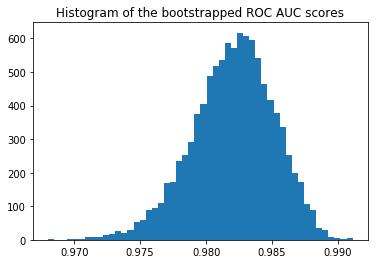

In [29]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.savefig('../output/bootstrapped_auroc_10000.png')
plt.show()

In [30]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.977 - 0.987]


In [31]:
sorted_scores.mean()

0.9820452003698154

In [32]:
sorted_scores.std()

0.0030957017300870765

In [33]:
y_val.value_counts()

0    6839
1     332
Name: isFraud, dtype: int64

In [34]:
332*100/(6839+332)

4.62975875052294

Not too much variablity within the validation set from the confidence interval above. As such, the validation set is probably large enough to give us reliable AUROC scores. As we saw from ISLR, repeatedly calculating a statistic using samples (with replacement) from a validation set (bootstrapping) gives a sampling distribution that closely resembles the sampling distribution that would be calculated from calculating the statistic on samples drawn from the true population.

![bootstrapping](../output/bootstrapping.jpg "Bootstrapping")

# Repeated Holdout Validation

In [55]:
n_repeated_validations = 100
holdout_validation_scores = []

for n in range(n_repeated_validations):
    val_indices = np.random.randint(len(X), size=len(val_preds))
    X_val = X.iloc[val_indices, :]
    y_val = y.iloc[val_indices]
    X_train = X.drop(val_indices)
    y_train = y.drop(val_indices)

    # Create arrays for oof predictions and sub predictions
    val_preds = np.zeros(len(X_val))

    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                    early_stopping_rounds=early_rounds)

    # Predict on test sets

    val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

    score = roc_auc_score(y_val.values, val_preds)
    holdout_validation_scores.append(score)
    
    print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994945	valid_1's auc: 0.971622
[100]	training's auc: 0.999329	valid_1's auc: 0.976145
[150]	training's auc: 0.999886	valid_1's auc: 0.976733
[200]	training's auc: 0.999981	valid_1's auc: 0.975427
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.975427
AUROC on validation set: 0.97542742461515


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994823	valid_1's auc: 0.96956
[100]	training's auc: 0.99933	valid_1's auc: 0.975927
[150]	training's auc: 0.999894	valid_1's auc: 0.977045
[200]	training's auc: 0.999984	valid_1's auc: 0.978021
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.978021
AUROC on validation set: 0.978020870482068


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995026	valid_1's auc: 0.976432
[100]	training's auc: 0.999313	valid_1's auc: 0.979697
[150]	training's auc: 0.999885	valid_1's auc: 0.98028
[200]	training's auc: 0.99998	valid_1's auc: 0.979132
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.979132
AUROC on validation set: 0.979132205861037


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994961	valid_1's auc: 0.970857
[100]	training's auc: 0.999362	valid_1's auc: 0.977043
[150]	training's auc: 0.999896	valid_1's auc: 0.977009
Early stopping, best iteration is:
[105]	training's auc: 0.999473	valid_1's auc: 0.977358
AUROC on validation set: 0.9773575666433432


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994798	valid_1's auc: 0.967035
[100]	training's auc: 0.999335	valid_1's auc: 0.97256
[150]	training's auc: 0.999892	valid_1's auc: 0.973865
[200]	training's auc: 0.999982	valid_1's auc: 0.973121
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.973121
AUROC on validation set: 0.9731211512945258


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994904	valid_1's auc: 0.968747
[100]	training's auc: 0.999364	valid_1's auc: 0.975745
[150]	training's auc: 0.999899	valid_1's auc: 0.976037
[200]	training's auc: 0.999982	valid_1's auc: 0.976144
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.976144
AUROC on validation set: 0.9761441164569871


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994835	valid_1's auc: 0.973112
[100]	training's auc: 0.999294	valid_1's auc: 0.979909
[150]	training's auc: 0.999888	valid_1's auc: 0.981871
[200]	training's auc: 0.99998	valid_1's auc: 0.982733
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.982733
AUROC on validation set: 0.982732957723967


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994938	valid_1's auc: 0.979609
[100]	training's auc: 0.999309	valid_1's auc: 0.980359
[150]	training's auc: 0.999886	valid_1's auc: 0.980326
[200]	training's auc: 0.999979	valid_1's auc: 0.979848
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.979848
AUROC on validation set: 0.979848191081226


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994974	valid_1's auc: 0.973382
[100]	training's auc: 0.999336	valid_1's auc: 0.979346
[150]	training's auc: 0.999889	valid_1's auc: 0.980401
[200]	training's auc: 0.999979	valid_1's auc: 0.980561
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.980561
AUROC on validation set: 0.9805612422381328


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99492	valid_1's auc: 0.967866
[100]	training's auc: 0.999337	valid_1's auc: 0.977339
[150]	training's auc: 0.999891	valid_1's auc: 0.978448
[200]	training's auc: 0.99998	valid_1's auc: 0.979375
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.979375
AUROC on validation set: 0.9793754289213421


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994927	valid_1's auc: 0.980909
[100]	training's auc: 0.999325	valid_1's auc: 0.981925
Early stopping, best iteration is:
[83]	training's auc: 0.998674	valid_1's auc: 0.982321
AUROC on validation set: 0.9823208760435321


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995078	valid_1's auc: 0.96195
[100]	training's auc: 0.999333	valid_1's auc: 0.971438
[150]	training's auc: 0.999889	valid_1's auc: 0.972642
[200]	training's auc: 0.999981	valid_1's auc: 0.973221
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.973221
AUROC on validation set: 0.9732214033829626


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994895	valid_1's auc: 0.970412
[100]	training's auc: 0.999329	valid_1's auc: 0.973147
[150]	training's auc: 0.99989	valid_1's auc: 0.974654
[200]	training's auc: 0.999981	valid_1's auc: 0.975031
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.975031
AUROC on validation set: 0.9750313720901956


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994886	valid_1's auc: 0.984445
[100]	training's auc: 0.99932	valid_1's auc: 0.987505
[150]	training's auc: 0.999885	valid_1's auc: 0.988626
[200]	training's auc: 0.99998	valid_1's auc: 0.988724
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.988724
AUROC on validation set: 0.9887241728073978


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994902	valid_1's auc: 0.968031
[100]	training's auc: 0.999332	valid_1's auc: 0.972292
[150]	training's auc: 0.999891	valid_1's auc: 0.973362
[200]	training's auc: 0.999983	valid_1's auc: 0.974311
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.974311
AUROC on validation set: 0.9743110681002362


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994987	valid_1's auc: 0.974916
[100]	training's auc: 0.999338	valid_1's auc: 0.980629
[150]	training's auc: 0.999897	valid_1's auc: 0.980996
Early stopping, best iteration is:
[122]	training's auc: 0.99971	valid_1's auc: 0.981335
AUROC on validation set: 0.9813345502632035


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995011	valid_1's auc: 0.981832
[100]	training's auc: 0.999339	valid_1's auc: 0.985009
[150]	training's auc: 0.999897	valid_1's auc: 0.986674
[200]	training's auc: 0.999983	valid_1's auc: 0.987629
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.987629
AUROC on validation set: 0.9876292347566751


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994871	valid_1's auc: 0.970914
[100]	training's auc: 0.999326	valid_1's auc: 0.976667
[150]	training's auc: 0.999894	valid_1's auc: 0.976671
Early stopping, best iteration is:
[110]	training's auc: 0.999535	valid_1's auc: 0.977207
AUROC on validation set: 0.977207245870325


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99488	valid_1's auc: 0.973132
[100]	training's auc: 0.999342	valid_1's auc: 0.977745
[150]	training's auc: 0.999897	valid_1's auc: 0.977805
Early stopping, best iteration is:
[123]	training's auc: 0.999717	valid_1's auc: 0.978041
AUROC on validation set: 0.9780412303233881


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994852	valid_1's auc: 0.97621
[100]	training's auc: 0.999345	valid_1's auc: 0.98423
[150]	training's auc: 0.999898	valid_1's auc: 0.987126
[200]	training's auc: 0.999984	valid_1's auc: 0.987444
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.987444
AUROC on validation set: 0.9874440756241882


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994984	valid_1's auc: 0.980869
[100]	training's auc: 0.99936	valid_1's auc: 0.986721
[150]	training's auc: 0.999905	valid_1's auc: 0.987629
[200]	training's auc: 0.999984	valid_1's auc: 0.987554
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.987554
AUROC on validation set: 0.9875544036383196


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994841	valid_1's auc: 0.962688
[100]	training's auc: 0.999314	valid_1's auc: 0.968157
[150]	training's auc: 0.999889	valid_1's auc: 0.970538
[200]	training's auc: 0.999981	valid_1's auc: 0.971835
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.971835
AUROC on validation set: 0.9718350858011061


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995032	valid_1's auc: 0.975564
[100]	training's auc: 0.999346	valid_1's auc: 0.981012
[150]	training's auc: 0.999897	valid_1's auc: 0.982251
Early stopping, best iteration is:
[132]	training's auc: 0.999803	valid_1's auc: 0.982584
AUROC on validation set: 0.9825836820083681


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994796	valid_1's auc: 0.97185
[100]	training's auc: 0.999313	valid_1's auc: 0.976359
[150]	training's auc: 0.999882	valid_1's auc: 0.977205
Early stopping, best iteration is:
[127]	training's auc: 0.999744	valid_1's auc: 0.977792
AUROC on validation set: 0.9777920543574723


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994874	valid_1's auc: 0.971906
[100]	training's auc: 0.999302	valid_1's auc: 0.979474
[150]	training's auc: 0.999894	valid_1's auc: 0.981761
[200]	training's auc: 0.999981	valid_1's auc: 0.981655
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.981655
AUROC on validation set: 0.9816549292428174


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994917	valid_1's auc: 0.963716
[100]	training's auc: 0.999346	valid_1's auc: 0.97072
[150]	training's auc: 0.999902	valid_1's auc: 0.972085
[200]	training's auc: 0.999984	valid_1's auc: 0.972649
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.972649
AUROC on validation set: 0.9726489882739882


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99499	valid_1's auc: 0.974268
[100]	training's auc: 0.999349	valid_1's auc: 0.981324
[150]	training's auc: 0.999895	valid_1's auc: 0.982116
[200]	training's auc: 0.999981	valid_1's auc: 0.982609
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.982609
AUROC on validation set: 0.9826085080898921


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99493	valid_1's auc: 0.96871
[100]	training's auc: 0.999345	valid_1's auc: 0.972313
[150]	training's auc: 0.999898	valid_1's auc: 0.972841
Early stopping, best iteration is:
[144]	training's auc: 0.999871	valid_1's auc: 0.973425
AUROC on validation set: 0.973424599409501


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994812	valid_1's auc: 0.974672
[100]	training's auc: 0.999317	valid_1's auc: 0.978685
[150]	training's auc: 0.99989	valid_1's auc: 0.979459
[200]	training's auc: 0.999982	valid_1's auc: 0.979059
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.979059
AUROC on validation set: 0.9790590118284787


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994815	valid_1's auc: 0.968861
[100]	training's auc: 0.9993	valid_1's auc: 0.975753
[150]	training's auc: 0.999885	valid_1's auc: 0.977365
[200]	training's auc: 0.999978	valid_1's auc: 0.97718
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999978	valid_1's auc: 0.97718
AUROC on validation set: 0.9771796637193796


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994875	valid_1's auc: 0.966633
[100]	training's auc: 0.999311	valid_1's auc: 0.975663
[150]	training's auc: 0.999884	valid_1's auc: 0.977838
[200]	training's auc: 0.999979	valid_1's auc: 0.978438
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.978438
AUROC on validation set: 0.9784376098617585


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994823	valid_1's auc: 0.9753
[100]	training's auc: 0.999307	valid_1's auc: 0.978899
Early stopping, best iteration is:
[98]	training's auc: 0.999249	valid_1's auc: 0.979169
AUROC on validation set: 0.9791690426633973


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994935	valid_1's auc: 0.977513
[100]	training's auc: 0.999336	valid_1's auc: 0.979632
[150]	training's auc: 0.999892	valid_1's auc: 0.979587
Early stopping, best iteration is:
[118]	training's auc: 0.999657	valid_1's auc: 0.980089
AUROC on validation set: 0.9800887973574762


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994886	valid_1's auc: 0.977942
[100]	training's auc: 0.999339	valid_1's auc: 0.982804
[150]	training's auc: 0.999898	valid_1's auc: 0.982986
Early stopping, best iteration is:
[133]	training's auc: 0.999805	valid_1's auc: 0.98346
AUROC on validation set: 0.9834599595651556


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994857	valid_1's auc: 0.9684
[100]	training's auc: 0.999299	valid_1's auc: 0.976232
[150]	training's auc: 0.99989	valid_1's auc: 0.978537
[200]	training's auc: 0.999981	valid_1's auc: 0.978708
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.978708
AUROC on validation set: 0.9787082150853917


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995073	valid_1's auc: 0.96493
[100]	training's auc: 0.999339	valid_1's auc: 0.968776
[150]	training's auc: 0.999894	valid_1's auc: 0.971087
[200]	training's auc: 0.999983	valid_1's auc: 0.972068
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.972068
AUROC on validation set: 0.9720675592293342


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994856	valid_1's auc: 0.981814
[100]	training's auc: 0.999348	valid_1's auc: 0.986454
[150]	training's auc: 0.999897	valid_1's auc: 0.987497
Early stopping, best iteration is:
[144]	training's auc: 0.999873	valid_1's auc: 0.987574
AUROC on validation set: 0.9875736258404906


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994996	valid_1's auc: 0.97204
[100]	training's auc: 0.999296	valid_1's auc: 0.978453
[150]	training's auc: 0.999888	valid_1's auc: 0.980562
Early stopping, best iteration is:
[146]	training's auc: 0.99987	valid_1's auc: 0.980629
AUROC on validation set: 0.9806289293692283


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994769	valid_1's auc: 0.984571
[100]	training's auc: 0.999336	valid_1's auc: 0.987863
[150]	training's auc: 0.999889	valid_1's auc: 0.989198
Early stopping, best iteration is:
[138]	training's auc: 0.999827	valid_1's auc: 0.989355
AUROC on validation set: 0.9893547828070777


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994848	valid_1's auc: 0.957298
[100]	training's auc: 0.999364	valid_1's auc: 0.964584
[150]	training's auc: 0.999887	valid_1's auc: 0.968181
[200]	training's auc: 0.999978	valid_1's auc: 0.968825
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999978	valid_1's auc: 0.968825
AUROC on validation set: 0.9688254102316602


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994915	valid_1's auc: 0.972693
[100]	training's auc: 0.99933	valid_1's auc: 0.97933
[150]	training's auc: 0.999888	valid_1's auc: 0.980112
[200]	training's auc: 0.999979	valid_1's auc: 0.980638
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.980638
AUROC on validation set: 0.9806380020321942


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994914	valid_1's auc: 0.962706
[100]	training's auc: 0.999364	valid_1's auc: 0.971261
[150]	training's auc: 0.999898	valid_1's auc: 0.97389
[200]	training's auc: 0.999981	valid_1's auc: 0.975137
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.975137
AUROC on validation set: 0.9751365586010534


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994855	valid_1's auc: 0.964938
[100]	training's auc: 0.999354	valid_1's auc: 0.972814
[150]	training's auc: 0.999889	valid_1's auc: 0.975179
[200]	training's auc: 0.99998	valid_1's auc: 0.975893
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.975893
AUROC on validation set: 0.9758932142459892


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994856	valid_1's auc: 0.971201
[100]	training's auc: 0.999345	valid_1's auc: 0.977334
[150]	training's auc: 0.99989	valid_1's auc: 0.978016
[200]	training's auc: 0.999981	valid_1's auc: 0.97892
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.97892
AUROC on validation set: 0.9789196310935441


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994771	valid_1's auc: 0.962365
[100]	training's auc: 0.999318	valid_1's auc: 0.970565
[150]	training's auc: 0.999893	valid_1's auc: 0.971324
Early stopping, best iteration is:
[135]	training's auc: 0.999816	valid_1's auc: 0.971807
AUROC on validation set: 0.9718066176116962


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994962	valid_1's auc: 0.968664
[100]	training's auc: 0.999328	valid_1's auc: 0.975783
[150]	training's auc: 0.999891	valid_1's auc: 0.975483
Early stopping, best iteration is:
[117]	training's auc: 0.99964	valid_1's auc: 0.976383
AUROC on validation set: 0.976383298280372


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99489	valid_1's auc: 0.967421
[100]	training's auc: 0.999324	valid_1's auc: 0.977749
[150]	training's auc: 0.999891	valid_1's auc: 0.979186
Early stopping, best iteration is:
[136]	training's auc: 0.999822	valid_1's auc: 0.979475
AUROC on validation set: 0.9794754543237716


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994879	valid_1's auc: 0.976357
[100]	training's auc: 0.999352	valid_1's auc: 0.98244
[150]	training's auc: 0.999902	valid_1's auc: 0.982477
Early stopping, best iteration is:
[117]	training's auc: 0.99966	valid_1's auc: 0.982792
AUROC on validation set: 0.982792222719357


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994829	valid_1's auc: 0.974223
[100]	training's auc: 0.999317	valid_1's auc: 0.981287
[150]	training's auc: 0.999893	valid_1's auc: 0.981963
[200]	training's auc: 0.999982	valid_1's auc: 0.98273
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.98273
AUROC on validation set: 0.9827300150829563


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994851	valid_1's auc: 0.970743
[100]	training's auc: 0.999292	valid_1's auc: 0.976483
[150]	training's auc: 0.999889	valid_1's auc: 0.978316
[200]	training's auc: 0.999983	valid_1's auc: 0.979565
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.979565
AUROC on validation set: 0.9795649605074943


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994875	valid_1's auc: 0.968029
[100]	training's auc: 0.999342	valid_1's auc: 0.974832
[150]	training's auc: 0.999887	valid_1's auc: 0.976807
[200]	training's auc: 0.999981	valid_1's auc: 0.977343
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.977343
AUROC on validation set: 0.9773432449903039


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994895	valid_1's auc: 0.983941
[100]	training's auc: 0.999312	valid_1's auc: 0.989539
[150]	training's auc: 0.999895	valid_1's auc: 0.990675
[200]	training's auc: 0.999982	valid_1's auc: 0.991251
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.991251
AUROC on validation set: 0.9912508487027369


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994836	valid_1's auc: 0.969713
[100]	training's auc: 0.999325	valid_1's auc: 0.973594
[150]	training's auc: 0.999893	valid_1's auc: 0.974657
[200]	training's auc: 0.999982	valid_1's auc: 0.974914
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.974914
AUROC on validation set: 0.9749135584492018


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994723	valid_1's auc: 0.971312
[100]	training's auc: 0.999294	valid_1's auc: 0.97686
[150]	training's auc: 0.99988	valid_1's auc: 0.978028
[200]	training's auc: 0.999979	valid_1's auc: 0.978874
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.978874
AUROC on validation set: 0.9788737165931729


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994674	valid_1's auc: 0.982684
[100]	training's auc: 0.999315	valid_1's auc: 0.985233
[150]	training's auc: 0.999887	valid_1's auc: 0.986164
[200]	training's auc: 0.999979	valid_1's auc: 0.986023
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.986023
AUROC on validation set: 0.9860233963692218


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994754	valid_1's auc: 0.975363
[100]	training's auc: 0.999315	valid_1's auc: 0.978821
[150]	training's auc: 0.999888	valid_1's auc: 0.981376
[200]	training's auc: 0.999982	valid_1's auc: 0.98121
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.98121
AUROC on validation set: 0.9812098118599666


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994855	valid_1's auc: 0.972332
[100]	training's auc: 0.999315	valid_1's auc: 0.980219
[150]	training's auc: 0.999896	valid_1's auc: 0.980912
[200]	training's auc: 0.99998	valid_1's auc: 0.981415
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.981415
AUROC on validation set: 0.9814152609539499


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994832	valid_1's auc: 0.9724
[100]	training's auc: 0.999308	valid_1's auc: 0.97828
[150]	training's auc: 0.999884	valid_1's auc: 0.980525
[200]	training's auc: 0.999979	valid_1's auc: 0.982371
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.982371
AUROC on validation set: 0.9823707330241231


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995007	valid_1's auc: 0.968908
[100]	training's auc: 0.999355	valid_1's auc: 0.976904
[150]	training's auc: 0.999898	valid_1's auc: 0.978184
[200]	training's auc: 0.999982	valid_1's auc: 0.978366
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.978366
AUROC on validation set: 0.9783664447142475


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994853	valid_1's auc: 0.977088
[100]	training's auc: 0.999331	valid_1's auc: 0.982793
[150]	training's auc: 0.999894	valid_1's auc: 0.98498
[200]	training's auc: 0.999982	valid_1's auc: 0.984933
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.984933
AUROC on validation set: 0.9849325066808696


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994918	valid_1's auc: 0.969634
[100]	training's auc: 0.999343	valid_1's auc: 0.973539
[150]	training's auc: 0.999893	valid_1's auc: 0.974592
Early stopping, best iteration is:
[135]	training's auc: 0.999817	valid_1's auc: 0.974927
AUROC on validation set: 0.9749268167803835


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994788	valid_1's auc: 0.969348
[100]	training's auc: 0.999304	valid_1's auc: 0.976539
[150]	training's auc: 0.999891	valid_1's auc: 0.976652
Early stopping, best iteration is:
[141]	training's auc: 0.999847	valid_1's auc: 0.976794
AUROC on validation set: 0.9767938297350062


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994865	valid_1's auc: 0.973565
[100]	training's auc: 0.999322	valid_1's auc: 0.978225
[150]	training's auc: 0.9999	valid_1's auc: 0.9791
[200]	training's auc: 0.999981	valid_1's auc: 0.979122
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.979122
AUROC on validation set: 0.9791222393662347


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994852	valid_1's auc: 0.972592
[100]	training's auc: 0.999339	valid_1's auc: 0.979545
[150]	training's auc: 0.999898	valid_1's auc: 0.979662
[200]	training's auc: 0.999984	valid_1's auc: 0.980322
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.980322
AUROC on validation set: 0.9803224967490248


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994982	valid_1's auc: 0.966047
[100]	training's auc: 0.999358	valid_1's auc: 0.970289
[150]	training's auc: 0.999894	valid_1's auc: 0.970246
[200]	training's auc: 0.999981	valid_1's auc: 0.971387
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.971387
AUROC on validation set: 0.9713874611174875


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994965	valid_1's auc: 0.975385
[100]	training's auc: 0.999362	valid_1's auc: 0.978352
[150]	training's auc: 0.999901	valid_1's auc: 0.979056
[200]	training's auc: 0.999983	valid_1's auc: 0.979516
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.979516
AUROC on validation set: 0.9795156188150176


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994845	valid_1's auc: 0.976103
[100]	training's auc: 0.999251	valid_1's auc: 0.980286
[150]	training's auc: 0.999883	valid_1's auc: 0.981505
[200]	training's auc: 0.999979	valid_1's auc: 0.981646
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.981646
AUROC on validation set: 0.9816462473804204


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994879	valid_1's auc: 0.962109
[100]	training's auc: 0.999347	valid_1's auc: 0.97118
[150]	training's auc: 0.999901	valid_1's auc: 0.97444
[200]	training's auc: 0.999984	valid_1's auc: 0.974565
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.974565
AUROC on validation set: 0.974564539579874


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994856	valid_1's auc: 0.974878
[100]	training's auc: 0.999315	valid_1's auc: 0.981427
[150]	training's auc: 0.999893	valid_1's auc: 0.982288
[200]	training's auc: 0.999981	valid_1's auc: 0.982409
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.982409
AUROC on validation set: 0.9824087745201433


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994894	valid_1's auc: 0.970962
[100]	training's auc: 0.999334	valid_1's auc: 0.978199
[150]	training's auc: 0.999894	valid_1's auc: 0.979132
[200]	training's auc: 0.999981	valid_1's auc: 0.980325
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.980325
AUROC on validation set: 0.9803246333732376


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994916	valid_1's auc: 0.969575
[100]	training's auc: 0.999294	valid_1's auc: 0.977485
[150]	training's auc: 0.999884	valid_1's auc: 0.979472
[200]	training's auc: 0.99998	valid_1's auc: 0.979559
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.979559
AUROC on validation set: 0.9795589287958516


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994872	valid_1's auc: 0.975101
[100]	training's auc: 0.999345	valid_1's auc: 0.981234
[150]	training's auc: 0.999897	valid_1's auc: 0.983055
[200]	training's auc: 0.999983	valid_1's auc: 0.983815
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.983815
AUROC on validation set: 0.9838147394695159


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995027	valid_1's auc: 0.970514
[100]	training's auc: 0.999328	valid_1's auc: 0.978776
[150]	training's auc: 0.999891	valid_1's auc: 0.98012
[200]	training's auc: 0.99998	valid_1's auc: 0.981056
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.981056
AUROC on validation set: 0.9810556714262795


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994861	valid_1's auc: 0.965468
[100]	training's auc: 0.999354	valid_1's auc: 0.9736
[150]	training's auc: 0.999904	valid_1's auc: 0.975497
[200]	training's auc: 0.999982	valid_1's auc: 0.975598
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.975598
AUROC on validation set: 0.9755981596295936


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995007	valid_1's auc: 0.973369
[100]	training's auc: 0.999315	valid_1's auc: 0.978206
[150]	training's auc: 0.999884	valid_1's auc: 0.979688
[200]	training's auc: 0.999979	valid_1's auc: 0.980678
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.980678
AUROC on validation set: 0.9806783018908869


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994834	valid_1's auc: 0.968427
[100]	training's auc: 0.999317	valid_1's auc: 0.973179
[150]	training's auc: 0.999884	valid_1's auc: 0.974084
[200]	training's auc: 0.999981	valid_1's auc: 0.974731
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.974731
AUROC on validation set: 0.9747306168469798


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994934	valid_1's auc: 0.976739
[100]	training's auc: 0.999366	valid_1's auc: 0.983335
[150]	training's auc: 0.9999	valid_1's auc: 0.9857
Early stopping, best iteration is:
[138]	training's auc: 0.999848	valid_1's auc: 0.985742
AUROC on validation set: 0.9857423957250221


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994717	valid_1's auc: 0.971615
[100]	training's auc: 0.999326	valid_1's auc: 0.978662
[150]	training's auc: 0.999891	valid_1's auc: 0.980655
[200]	training's auc: 0.999982	valid_1's auc: 0.980919
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.980919
AUROC on validation set: 0.980918895582876


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994913	valid_1's auc: 0.967979
[100]	training's auc: 0.999365	valid_1's auc: 0.974902
[150]	training's auc: 0.999903	valid_1's auc: 0.9755
Early stopping, best iteration is:
[147]	training's auc: 0.99989	valid_1's auc: 0.975734
AUROC on validation set: 0.9757340589393915


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994843	valid_1's auc: 0.976416
[100]	training's auc: 0.999347	valid_1's auc: 0.981536
[150]	training's auc: 0.999894	valid_1's auc: 0.982568
[200]	training's auc: 0.999981	valid_1's auc: 0.983035
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.983035
AUROC on validation set: 0.9830350686912509


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99483	valid_1's auc: 0.975086
[100]	training's auc: 0.99934	valid_1's auc: 0.979796
[150]	training's auc: 0.999891	valid_1's auc: 0.981135
[200]	training's auc: 0.999982	valid_1's auc: 0.981493
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.981493
AUROC on validation set: 0.9814926626613196


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994864	valid_1's auc: 0.965531
[100]	training's auc: 0.999362	valid_1's auc: 0.976908
[150]	training's auc: 0.999897	valid_1's auc: 0.978376
Early stopping, best iteration is:
[139]	training's auc: 0.999843	valid_1's auc: 0.978458
AUROC on validation set: 0.9784583002735473


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994846	valid_1's auc: 0.977053
[100]	training's auc: 0.99931	valid_1's auc: 0.981019
[150]	training's auc: 0.999894	valid_1's auc: 0.981588
[200]	training's auc: 0.999983	valid_1's auc: 0.981886
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.981886
AUROC on validation set: 0.9818860409255374


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994905	valid_1's auc: 0.979832
[100]	training's auc: 0.999266	valid_1's auc: 0.98591
[150]	training's auc: 0.999881	valid_1's auc: 0.986926
[200]	training's auc: 0.999978	valid_1's auc: 0.986641
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999978	valid_1's auc: 0.986641
AUROC on validation set: 0.9866414437812685


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994931	valid_1's auc: 0.964543
[100]	training's auc: 0.999341	valid_1's auc: 0.97609
[150]	training's auc: 0.999898	valid_1's auc: 0.979192
[200]	training's auc: 0.999983	valid_1's auc: 0.980301
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.980301
AUROC on validation set: 0.980300624655247


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99507	valid_1's auc: 0.978152
[100]	training's auc: 0.999295	valid_1's auc: 0.981591
[150]	training's auc: 0.99989	valid_1's auc: 0.982717
[200]	training's auc: 0.999982	valid_1's auc: 0.982609
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.982609
AUROC on validation set: 0.9826094944969982


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99493	valid_1's auc: 0.967391
[100]	training's auc: 0.999335	valid_1's auc: 0.974066
[150]	training's auc: 0.999892	valid_1's auc: 0.976318
Early stopping, best iteration is:
[143]	training's auc: 0.999861	valid_1's auc: 0.977076
AUROC on validation set: 0.9770758084138192


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994945	valid_1's auc: 0.964564
[100]	training's auc: 0.999348	valid_1's auc: 0.970069
[150]	training's auc: 0.999904	valid_1's auc: 0.972279
[200]	training's auc: 0.999983	valid_1's auc: 0.972877
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.972877
AUROC on validation set: 0.9728771995529628


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994885	valid_1's auc: 0.980583
[100]	training's auc: 0.999322	valid_1's auc: 0.985472
[150]	training's auc: 0.999894	valid_1's auc: 0.985856
Early stopping, best iteration is:
[141]	training's auc: 0.999852	valid_1's auc: 0.986352
AUROC on validation set: 0.9863521715446713


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994974	valid_1's auc: 0.975463
[100]	training's auc: 0.999338	valid_1's auc: 0.98038
[150]	training's auc: 0.999898	valid_1's auc: 0.981934
[200]	training's auc: 0.999984	valid_1's auc: 0.982032
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.982032
AUROC on validation set: 0.9820321498694136


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994901	valid_1's auc: 0.971737
[100]	training's auc: 0.999312	valid_1's auc: 0.976915
[150]	training's auc: 0.999889	valid_1's auc: 0.976635
Early stopping, best iteration is:
[123]	training's auc: 0.999708	valid_1's auc: 0.977317
AUROC on validation set: 0.9773171059856223


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994774	valid_1's auc: 0.971313
[100]	training's auc: 0.999318	valid_1's auc: 0.979184
[150]	training's auc: 0.999893	valid_1's auc: 0.981271
[200]	training's auc: 0.999982	valid_1's auc: 0.981588
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999982	valid_1's auc: 0.981588
AUROC on validation set: 0.9815878753058991


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994769	valid_1's auc: 0.973005
[100]	training's auc: 0.999324	valid_1's auc: 0.978027
[150]	training's auc: 0.999892	valid_1's auc: 0.978666
[200]	training's auc: 0.999981	valid_1's auc: 0.979142
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.979142
AUROC on validation set: 0.9791420189486847


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994998	valid_1's auc: 0.976973
[100]	training's auc: 0.99933	valid_1's auc: 0.981692
[150]	training's auc: 0.999888	valid_1's auc: 0.98221
[200]	training's auc: 0.99998	valid_1's auc: 0.982607
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.99998	valid_1's auc: 0.982607
AUROC on validation set: 0.9826074961110621


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994927	valid_1's auc: 0.979378
[100]	training's auc: 0.999304	valid_1's auc: 0.986892
[150]	training's auc: 0.999888	valid_1's auc: 0.988435
[200]	training's auc: 0.999979	valid_1's auc: 0.989106
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999979	valid_1's auc: 0.989106
AUROC on validation set: 0.9891060037307418


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994792	valid_1's auc: 0.979276
[100]	training's auc: 0.999332	valid_1's auc: 0.981997
[150]	training's auc: 0.999891	valid_1's auc: 0.98311
[200]	training's auc: 0.999981	valid_1's auc: 0.9831
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.9831
AUROC on validation set: 0.9830997614944695


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994854	valid_1's auc: 0.967889
[100]	training's auc: 0.999309	valid_1's auc: 0.971946
[150]	training's auc: 0.999896	valid_1's auc: 0.97114
Early stopping, best iteration is:
[116]	training's auc: 0.999625	valid_1's auc: 0.972109
AUROC on validation set: 0.9721090055455381


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994935	valid_1's auc: 0.978594
[100]	training's auc: 0.999357	valid_1's auc: 0.984804
[150]	training's auc: 0.999895	valid_1's auc: 0.98507
[200]	training's auc: 0.999981	valid_1's auc: 0.985902
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999981	valid_1's auc: 0.985902
AUROC on validation set: 0.9859015683462432


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994815	valid_1's auc: 0.970121
[100]	training's auc: 0.999312	valid_1's auc: 0.977096
[150]	training's auc: 0.999894	valid_1's auc: 0.977554
[200]	training's auc: 0.999983	valid_1's auc: 0.978036
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999983	valid_1's auc: 0.978036
AUROC on validation set: 0.9780361714281295


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.99489	valid_1's auc: 0.975246
[100]	training's auc: 0.999332	valid_1's auc: 0.978648
[150]	training's auc: 0.999896	valid_1's auc: 0.979669
[200]	training's auc: 0.999984	valid_1's auc: 0.980088
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999984	valid_1's auc: 0.980088
AUROC on validation set: 0.9800883337141467


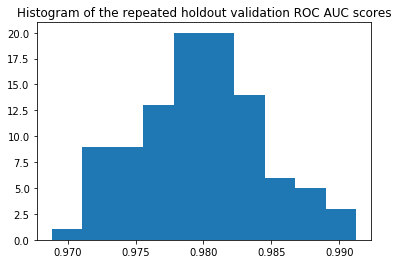

In [67]:
plt.figure()
plt.hist(holdout_validation_scores, bins=10)
plt.title('Histogram of the repeated holdout validation ROC AUC scores')
plt.savefig('../output/repeated_holdout_validation_100.png')
plt.show()

In [70]:
np.mean(holdout_validation_scores)

0.9797228147099619

In [71]:
np.std(holdout_validation_scores)

0.004501755980563615

In [68]:
sorted_scores = np.array(holdout_validation_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.972 - 0.988]


Little variability between AUROC on validation sets of size 7171 samples

# Save submission predictions

In [35]:
sub_df['isFraud'] = sub_preds
sub_df.to_csv('../submissions/submission_2.csv', index=False)

# Feature importances

In [36]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [37]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [38]:
feature_importance_df.head()

,feature,importance
2,card1,7625
0,TransactionAmt,5697
8,addr1,3644
431,card1_count,3105
10,dist1,2659


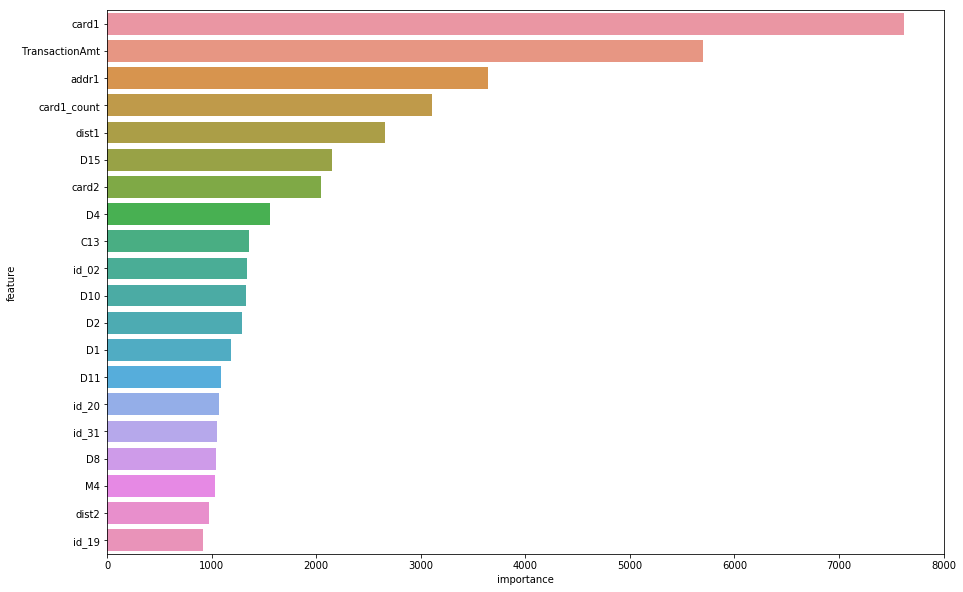

In [39]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [41]:
# Save average feature importances
feature_importance_df.to_csv('../output/lightgbm_importance_card1_count_encoded.csv', index=False)